In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [59]:
from utils import *

# Expérimentations et analyses

On cherche à comparer l'impact de la mesure de discrimination sur le classifieur en terme de taux de bonne classification et de monotonie, en testant les mesures sous les mêmes conditions expérimentales.

Pour cela, on étudie l'impact du bruit non monotone sur les performances des différentes mesures. 

In [4]:
g = Log()
h = Sum()

# rank Shannon discrimination measure
f_r = Dsr()
rsdm = Gdm(h, g, f_r)

# conditional Shannon entropy
f = Ds()
sdm = Gdm(h, g, f)

# pessimistic rank discrimination measure
f_p = Mindsr()
g_p = Frac() 
prdm = Gdm(h, g_p, f_p)

## Expérimentations sur des bases artificielles

Dans un premier temps, on étudie l'effet du bruit non-monotone sur nos mesures en générant des datasets artificiels avec un degré de bruit non monotone croissant.

### Datasets à deux dimensions dont une seule est monotone

### - 2 classes :

- 10 exemples : 

-> pas de bruit :

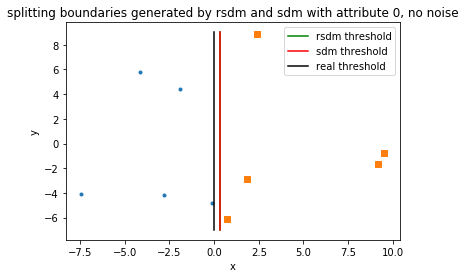

In [101]:
set2_10_0, t = generate_2Ddataset(0, 2, 10, 0., 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_0, 0)
t2, h2 = discretize(sdm, set2_10_0, 0)
display_discretizations_comparison(set2_10_0, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, no noise", "rsdm threshold", "sdm threshold")

In [102]:
train_set2_10_0, test_set2_10_0 = split_dataset(set2_10_0, 80)

depth :  2
number of leaves :  2
rule monotone :  True
accuracy :  0.5
rank shannon evaluation :  0.0


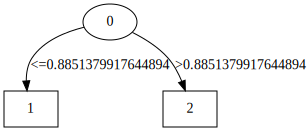

In [104]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(train_set2_10_0)
print("depth : ", rdmt2_10.get_depth())
print("number of leaves : ", rdmt2_10.get_nb_leaves())
print("rule monotone : ", rdmt2_10.is_rule_monotone())
print("accuracy : ", rdmt2_10.accuracy(test_set2_10_0))
#print(I_tree(rdmt2_10))
print("rank shannon evaluation : ", rdmt2_10.evaluate_monotonicity())
rdmt2_10.plot()

depth :  2
number of leaves :  2
rule monotone :  True
accuracy :  0.5
rank shannon evaluation :  0.0


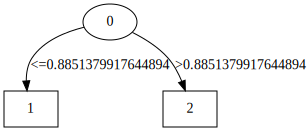

In [105]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(train_set2_10_0)
print("depth : ", dmt2_10.get_depth())
print("number of leaves : ", dmt2_10.get_nb_leaves())
print("rule monotone : ", dmt2_10.is_rule_monotone())
print("accuracy : ", dmt2_10.accuracy(test_set2_10_0))
print("rank shannon evaluation : ", dmt2_10.evaluate_monotonicity())
dmt2_10.plot()

-> 30% de bruit :

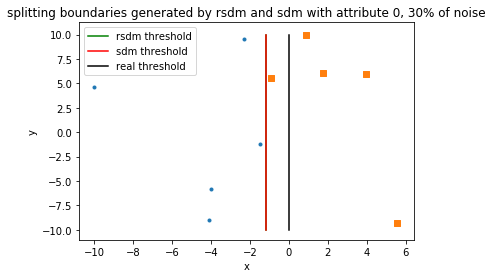

In [106]:
set2_10_30, t = generate_2Ddataset(0, 2, 10, 0.3, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_30, 0)
t2, h2 = discretize(sdm, set2_10_30, 0)
display_discretizations_comparison(set2_10_30, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 30% of noise", "rsdm threshold", "sdm threshold")

In [107]:
train_set2_10_30, test_set2_10_30 = split_dataset(set2_10_30, 80)

depth :  2
number of leaves :  2
rule monotone :  True
accuracy :  0.5
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.0
rank shannon evaluation :  0.0


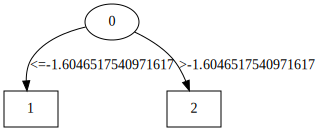

In [108]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(train_set2_10_30)
print("depth : ", rdmt2_10.get_depth())
print("number of leaves : ", rdmt2_10.get_nb_leaves())
print("rule monotone : ", rdmt2_10.is_rule_monotone())
print("accuracy : ", rdmt2_10.accuracy(test_set2_10_30))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_10.get_ratio_non_monotone_pairs())
print("rank shannon evaluation : ", rdmt2_10.evaluate_monotonicity())

rdmt2_10.plot()

depth :  2
number of leaves :  2
rule monotone :  True
accuracy :  0.5
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.0
rank shannon evaluation :  0.0


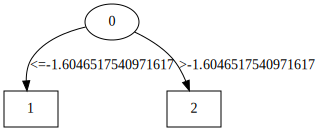

In [109]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(train_set2_10_30)
print("depth : ", dmt2_10.get_depth())
print("number of leaves : ", dmt2_10.get_nb_leaves())
print("rule monotone : ", dmt2_10.is_rule_monotone())
print("accuracy : ", dmt2_10.accuracy(test_set2_10_30))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_10.get_ratio_non_monotone_pairs())
print("rank shannon evaluation : ", dmt2_10.evaluate_monotonicity())

dmt2_10.plot()

-> 70% de bruit :

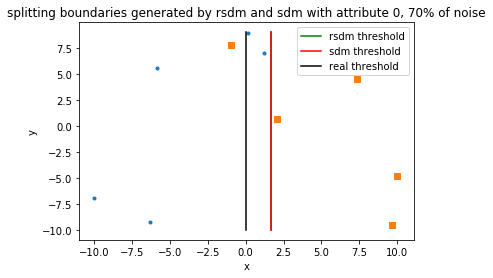

In [5]:
set2_10_70, t = generate_2Ddataset(0, 2, 10, 0.7, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_10_70, 0)
t2, h2 = discretize(sdm, set2_10_70, 0)
display_discretizations_comparison(set2_10_70, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 70% of noise", "rsdm threshold", "sdm threshold")

In [6]:
train_set2_10_70, test_set2_10_70 = split_dataset(set2_10_70, 80)

depth :  4
number of leaves :  4
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0
rank shannon evaluation :  0.5


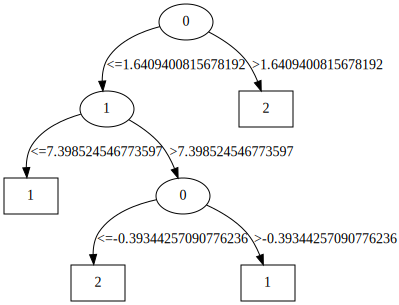

In [7]:
rdmt2_10 = RDMT(rsdm, "shannon", 0, 10, 0, [1, 2])
rdmt2_10.train(train_set2_10_70)
print("depth : ", rdmt2_10.get_depth())
print("number of leaves : ", rdmt2_10.get_nb_leaves())
print("rule monotone : ", rdmt2_10.is_rule_monotone())
print("accuracy : ", rdmt2_10.accuracy(test_set2_10_70))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_10.get_ratio_non_monotone_pairs())
print("rank shannon evaluation : ", rdmt2_10.evaluate_monotonicity())

rdmt2_10.plot()

depth :  4
number of leaves :  4
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0
rank shannon evaluation :  0.5


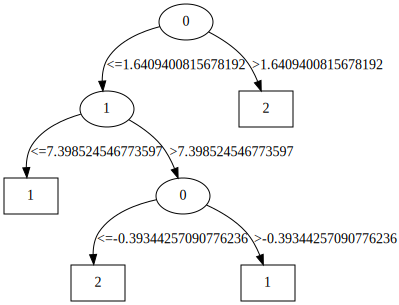

In [8]:
dmt2_10 = RDMT(sdm, "shannon", 0, 10, 0, [1, 2])
dmt2_10.train(train_set2_10_70)
print("depth : ", dmt2_10.get_depth())
print("number of leaves : ", dmt2_10.get_nb_leaves())
print("rule monotone : ", dmt2_10.is_rule_monotone())
print("accuracy : ", dmt2_10.accuracy(test_set2_10_70))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_10.get_ratio_non_monotone_pairs())
print("rank shannon evaluation : ", dmt2_10.evaluate_monotonicity())

dmt2_10.plot()

- 100 exemples :  

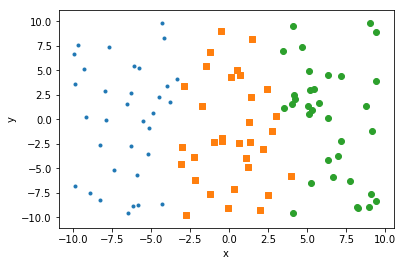

In [377]:
set2_100, t = generate_2Ddataset(0, 3, 100, 0.05, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set2_100, 0)
t2, h2 = discretize(sdm, set2_100, 0)
plot2DSet(set2_100, "")
# display_discretizations_comparison(set2_100, t1, t2, [0], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 10% of noise", "rsdm threshold", "sdm threshold")

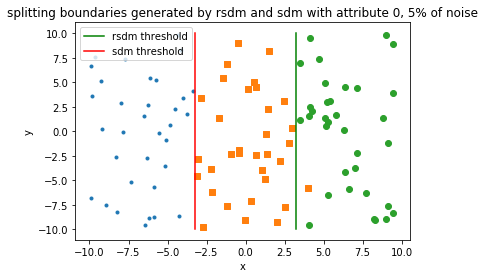

In [402]:
display_discretizations_comparison(set2_100, t1, t2, [], 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 5% of noise", "rsdm threshold", "sdm threshold")

In [378]:
train_set2_100, test_set2_100 = split_dataset(set2_100, 80)

In [379]:
sets2_100 = get_ten_folds(set2_100)

depth :  4
number of leaves :  5
rule monotone :  True
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.31645569620253167
number of nodes :  4
number of pairs :  2
pairs ratio :  0.5
average rank shannon evaluation :  0.0


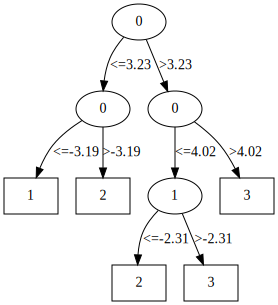

In [403]:
rdmt2_100 = RDMT(rsdm, "shannon", 0, 100, 0.01 * train_set2_100.size(), [1, 2, 3])
rdmt2_100.train(train_set2_100)
print("depth : ", rdmt2_100.get_depth())
print("number of leaves : ", rdmt2_100.get_nb_leaves())
print("rule monotone : ", rdmt2_100.is_rule_monotone())
print("accuracy : ", rdmt2_100.accuracy(test_set2_100))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_100.get_ratio_non_monotone_pairs())
print("number of nodes : ", rdmt2_100.get_nb_nodes())
print("number of pairs : ", rdmt2_100.get_total_pairs())
print("pairs ratio : ", rdmt2_100.pairs_ratio())
print("average rank shannon evaluation : ", rdmt2_100.evaluate_monotonicity())
rdmt2_100.plot()


depth :  4
number of leaves :  5
rule monotone :  True
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.31645569620253167
number of nodes :  4
number of pairs :  2
pairs ratio :  0.5
average rank shannon evaluation :  0.0


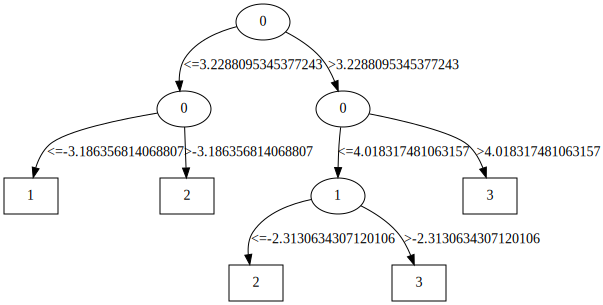

In [380]:
rdmt2_100 = RDMT(rsdm, "shannon", 0, 100, 0.01 * train_set2_100.size(), [1, 2, 3])
rdmt2_100.train(train_set2_100)
print("depth : ", rdmt2_100.get_depth())
print("number of leaves : ", rdmt2_100.get_nb_leaves())
print("rule monotone : ", rdmt2_100.is_rule_monotone())
print("accuracy : ", rdmt2_100.accuracy(test_set2_100))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", rdmt2_100.get_ratio_non_monotone_pairs())
print("number of nodes : ", rdmt2_100.get_nb_nodes())
print("number of pairs : ", rdmt2_100.get_total_pairs())
print("pairs ratio : ", rdmt2_100.pairs_ratio())
print("average rank shannon evaluation : ", rdmt2_100.evaluate_monotonicity())
rdmt2_100.plot()


depth :  5
number of leaves :  5
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0
number of nodes :  4
number of pairs :  1
pairs ratio :  0.25
average rank shannon evaluation :  0.5283208335737187


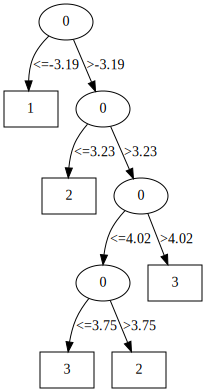

In [404]:
dmt2_100 = RDMT(sdm, "shannon", 0, 100, 0.01 * train_set2_100.size(), [1, 2, 3])
dmt2_100.train(train_set2_100)
print("depth : ", dmt2_100.get_depth())
print("number of leaves : ", dmt2_100.get_nb_leaves())
print("rule monotone : ", dmt2_100.is_rule_monotone())
print("accuracy : ", dmt2_100.accuracy(test_set2_100))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_100.get_ratio_non_monotone_pairs())
print("number of nodes : ", dmt2_100.get_nb_nodes())
print("number of pairs : ", dmt2_100.get_total_pairs())
print("pairs ratio : ", dmt2_100.pairs_ratio())
print("average rank shannon evaluation : ", dmt2_100.evaluate_monotonicity())
dmt2_100.plot()

depth :  5
number of leaves :  5
rule monotone :  False
accuracy :  1.0
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  1.0
number of nodes :  4
number of pairs :  1
pairs ratio :  0.25
average rank shannon evaluation :  0.5283208335737187


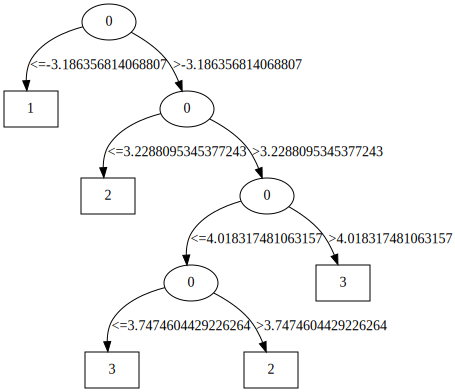

In [384]:
dmt2_100 = RDMT(sdm, "shannon", 0, 100, 0.01 * train_set2_100.size(), [1, 2, 3])
dmt2_100.train(train_set2_100)
print("depth : ", dmt2_100.get_depth())
print("number of leaves : ", dmt2_100.get_nb_leaves())
print("rule monotone : ", dmt2_100.is_rule_monotone())
print("accuracy : ", dmt2_100.accuracy(test_set2_100))
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", dmt2_100.get_ratio_non_monotone_pairs())
print("number of nodes : ", dmt2_100.get_nb_nodes())
print("number of pairs : ", dmt2_100.get_total_pairs())
print("pairs ratio : ", dmt2_100.pairs_ratio())
print("average rank shannon evaluation : ", dmt2_100.evaluate_monotonicity())
dmt2_100.plot()

In [385]:
avg_accuracy = 0
avg_leaves = 0
avg_depth = 0
avg_ratio = 0
avg_pairs = 0
avg_evaluation = 0

for i in range(10):
    test_set = sets2_100[i]
    train_set = LabeledSet(2)
    for j in range(0, 10):
        if i != j:
            train_set.addExamples(sets2_100[j].x, sets2_100[j].y)
    tree = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2, 3])
    tree.train(train_set)
    avg_accuracy += tree.accuracy(test_set)
    avg_leaves += tree.get_nb_leaves()
    avg_depth += tree.get_depth()
    avg_ratio += tree.get_ratio_non_monotone_pairs() 
    avg_pairs += tree.get_total_pairs()
    avg_evaluation += tree.evaluate_monotonicity()
        
avg_accuracy = avg_accuracy * (1.0/10)
avg_leaves = avg_leaves * (1.0/10)
avg_depth = avg_depth * (1.0/10)
avg_ratio = avg_ratio * (1.0/10)
avg_pairs = avg_pairs * (1.0/10)
avg_evaluation = avg_evaluation * (1.0/10)

print("average accuracy : ", avg_accuracy)
print("average depth : ", avg_depth)
print("average number of leaves : ", avg_leaves)
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", avg_ratio)
print("average number of pairs used for ratio computing : ", avg_pairs)
print("average rank shannon evaluation : ", avg_evaluation)

average accuracy :  0.9836257309941522
average depth :  3.9000000000000004
average number of leaves :  4.800000000000001
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.3220729887396554
average number of pairs used for ratio computing :  1.9000000000000001
average rank shannon evaluation :  0.0


In [386]:
avg_accuracy = 0
avg_leaves = 0
avg_depth = 0
avg_ratio = 0
avg_pairs = 0
avg_evaluation = 0

for i in range(10):
    test_set = sets2_100[i]
    train_set = LabeledSet(2)
    for j in range(0, 10):
        if i != j:
            train_set.addExamples(sets2_100[j].x, sets2_100[j].y)
    tree = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2, 3])
    tree.train(train_set)
    avg_accuracy += tree.accuracy(test_set)
    avg_leaves += tree.get_nb_leaves()
    avg_depth += tree.get_depth()
    avg_ratio += tree.get_ratio_non_monotone_pairs() 
    avg_pairs += tree.get_total_pairs()
    avg_evaluation += tree.evaluate_monotonicity()
        
avg_accuracy = avg_accuracy * (1.0/10)
avg_leaves = avg_leaves * (1.0/10)
avg_depth = avg_depth * (1.0/10)
avg_ratio = avg_ratio * (1.0/10)
avg_pairs = avg_pairs * (1.0/10)
avg_evaluation = avg_evaluation * (1.0/10)

print("average accuracy : ", avg_accuracy)
print("average depth : ", avg_depth)
print("average number of leaves : ", avg_leaves)
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", avg_ratio)
print("average number of pairs used for ratio computing : ", avg_pairs)
print("average rank shannon evaluation : ", avg_evaluation)

average accuracy :  0.9783625730994153
average depth :  4.800000000000001
average number of leaves :  4.800000000000001
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.934065934065934
average number of pairs used for ratio computing :  1.0
average rank shannon evaluation :  0.46982458350160317


In [399]:
y1 = []
y2 = []
y3 = []

avg_leaves1 = []
avg_leaves2 = []
# avg_leaves3 = []

avg_depth1 = []
avg_depth2 = []
# avg_depth3 = []

avg_ratio1 = []
avg_ratio2 = []
# avg_ratio3 = []

avg_pairs1 = []
avg_pairs2 = []
# avg_pairs3 = []

avg_eval1 = []
avg_eval2 = []
# avg_eval3 = []

start = time.time()

#dataset, t = generate_2Ddataset(0, 2, 1000, 0, 0.1, [[-10, 10], [-10, 10]])
dataset, t = generate_2Ddataset(0, 2, 100, 0, 0.1, [[-10, 10], [-10, 10]])

noises = []
noise = 0

for k in range(22):
    if k > 0:
        dataset = add_noise(dataset, 0.025)
    sets = get_ten_folds(dataset)
    noises.append(noise)
    
    acc1 = 0
    leaves1 = 0
    depth1 = 0
    ratio1 = 0
    pairs1 = 0
    eval1 = 0
    
    acc2 = 0
    leaves2 = 0
    depth2 = 0
    ratio2 = 0
    pairs2 = 0
    eval2 = 0
    
#     acc3 = 0
#     leaves3 = 0
#     depth3 = 0
#     ratio3 = 0
#     pairs3 = 0
#     eval3 = 0
    
    for i in range(10):
        test_set = sets[i]
        train_set = LabeledSet(2)
        for j in range(0, 10):
            if i != j:
                train_set.addExamples(sets[j].x, sets[j].y)
        tree1 = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2])
        tree1.train(train_set)
        acc1 += tree1.accuracy(test_set)
        leaves1 += tree1.get_nb_leaves()
        depth1 += tree1.get_depth()
        ratio1 += tree1.get_ratio_non_monotone_pairs() 
        pairs1 += tree1.get_total_pairs()
        eval1 += tree1.evaluate_monotonicity()
        
        tree2 = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2])
        tree2.train(train_set)
        acc2 += tree2.accuracy(test_set)
        leaves2 += tree2.get_nb_leaves()
        depth2 += tree2.get_depth()
        ratio2 += tree2.get_ratio_non_monotone_pairs() 
        pairs2 += tree2.get_total_pairs()
        eval2 += tree2.evaluate_monotonicity()
        
#         tree3 = RDMT(prdm, "shannon", 0, 100, 0.01, [1, 2])
#         tree3.train(train_set)
#         acc3 += tree3.accuracy(test_set)
#         leaves3 += tree3.get_nb_leaves()
#         depth3 += tree3.get_depth()
#         ratio3 += tree3.get_ratio_non_monotone_pairs() 
#         pairs3 += tree3.get_total_pairs()
#         eval3 += tree3.evaluate_monotonicity()
        
    y1.append(acc1 * (1.0/10))    
    avg_leaves1.append(leaves1 * (1.0/10))
    avg_depth1.append(depth1 * (1.0/10))
    avg_ratio1.append(ratio1 * (1.0/10))
    avg_pairs1.append(pairs1 * (1.0/10))
    avg_eval1.append(eval1 * (1.0/10))
    
    y2.append(acc2 * (1.0/10))    
    avg_leaves2.append(leaves2 * (1.0/10))
    avg_depth2.append(depth2 * (1.0/10))
    avg_ratio2.append(ratio2 * (1.0/10))
    avg_pairs2.append(pairs2 * (1.0/10))
    avg_eval2.append(eval2 * (1.0/10))
    
#     y3.append(acc3 * (1.0/10))    
#     avg_leaves3.append(leaves3 * (1.0/10))
#     avg_depth3.append(depth3 * (1.0/10))
#     avg_ratio3.append(ratio3 * (1.0/10))
#     avg_pairs3.append(pairs3 * (1.0/10))    
#     avg_eval3.append(eval3 * (1.0/10))
    
print("Running time : ", format(time.time() - start))

Running time :  356.22304606437683


In [389]:
x = np.array(noises) * 100
y1 = np.array(y1)
y2 = np.array(y2)
# y3 = np.array(y3)

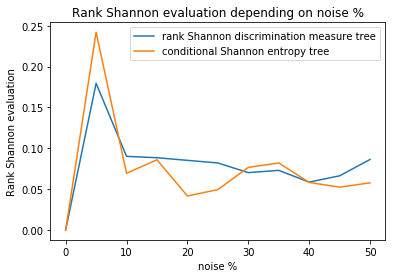

In [390]:
plt.plot(x, avg_eval1, label="rank Shannon discrimination measure tree")
plt.plot(x, avg_eval2, label="conditional Shannon entropy tree")
# plt.plot(x, avg_eval3, label="pessimistic rank discrimination measure tree")
plt.xlabel("noise %")
plt.ylabel("Rank Shannon evaluation")
plt.title("Rank Shannon evaluation depending on noise %")
plt.legend()
plt.show()

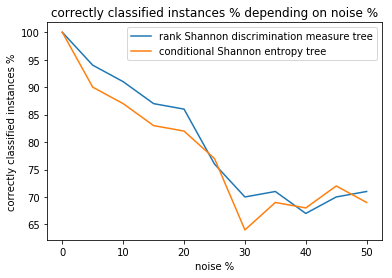

In [391]:
plt.plot(x, y1 * 100, label="rank Shannon discrimination measure tree")
plt.plot(x, y2 * 100, label="conditional Shannon entropy tree")
# plt.plot(x, y3 * 100, label="pessimistic rank discrimination measure tree")
plt.xlabel("noise %")
plt.ylabel("correctly classified instances %")
plt.title("correctly classified instances % depending on noise %")
plt.legend()
plt.show()

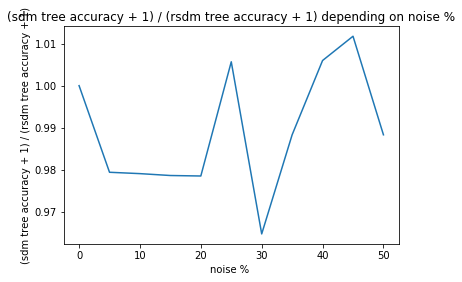

In [392]:
z = ((y2 + 1) / (y1 + 1))
plt.plot(x, z)
plt.xlabel("noise % ")
plt.ylabel("(sdm tree accuracy + 1) / (rsdm tree accuracy + 1)")
plt.title("(sdm tree accuracy + 1) / (rsdm tree accuracy + 1) depending on noise %")
plt.show()

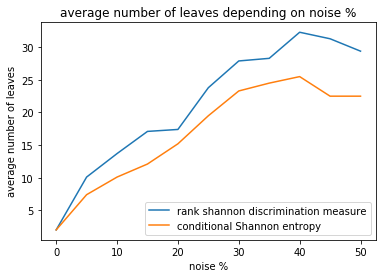

In [393]:
plt.plot(x, avg_leaves1, label="rank shannon discrimination measure")
plt.plot(x, avg_leaves2, label="conditional Shannon entropy")
# plt.plot(x, avg_leaves3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average number of leaves")
plt.title("average number of leaves depending on noise %")
plt.legend()
plt.show()

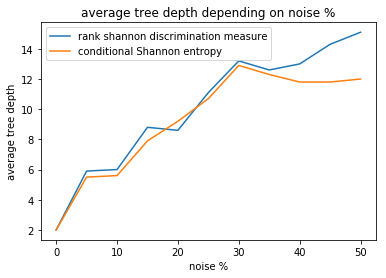

In [394]:
plt.plot(x, avg_depth1, label="rank shannon discrimination measure")
plt.plot(x, avg_depth2, label="conditional Shannon entropy")
# plt.plot(x, avg_depth3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average tree depth")
plt.title("average tree depth depending on noise %")
plt.legend()
plt.show()

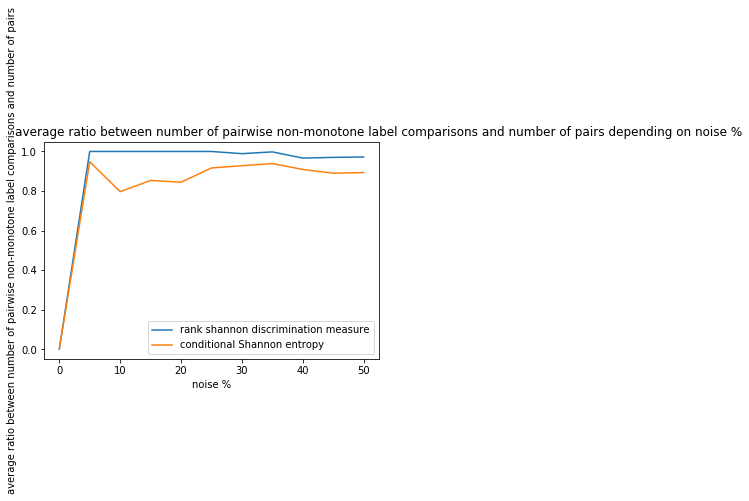

In [395]:
plt.plot(x, avg_ratio1, label="rank shannon discrimination measure")
plt.plot(x, avg_ratio2, label="conditional Shannon entropy")
# plt.plot(x, avg_ratio3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("average ratio between number of pairwise non-monotone label comparisons and number of pairs")
plt.title("average ratio between number of pairwise non-monotone label comparisons and number of pairs depending on noise %", x=1)
plt.legend()
plt.show()

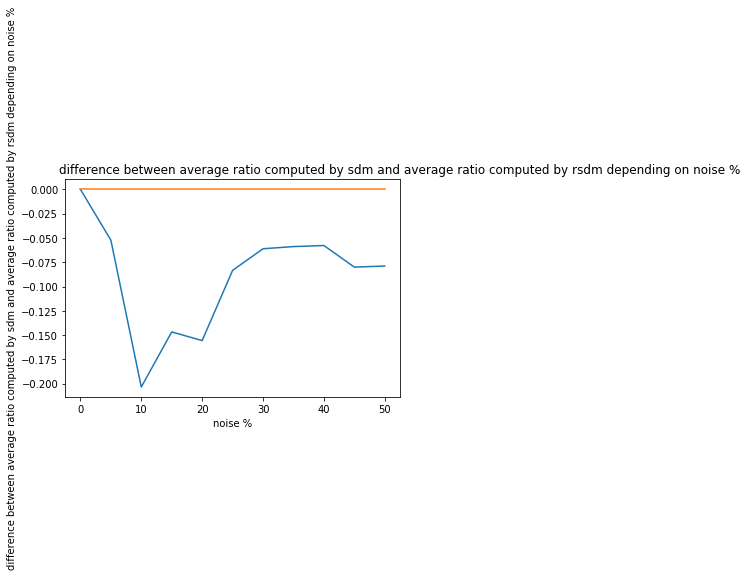

In [396]:
plt.plot(x, np.array(avg_ratio2) - np.array(avg_ratio1))
plt.plot(x, np.array([0] * len(x)))
plt.xlabel("noise %")
plt.ylabel("difference between average ratio computed by sdm and average ratio computed by rsdm depending on noise %")
plt.title("difference between average ratio computed by sdm and average ratio computed by rsdm depending on noise %", x=1)
plt.show()

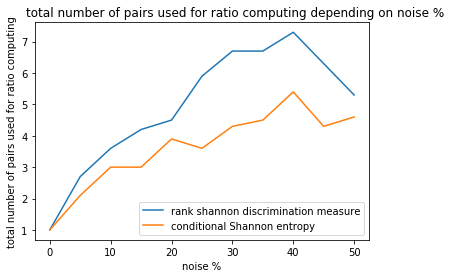

In [397]:
plt.plot(x, avg_pairs1, label="rank shannon discrimination measure")
plt.plot(x, avg_pairs2, label="conditional Shannon entropy")
# plt.plot(x, avg_pairs3, label="pessimistic rank discrimination measure")
plt.xlabel("noise %")
plt.ylabel("total number of pairs used for ratio computing")
plt.title("total number of pairs used for ratio computing depending on noise %", x=0.6)
plt.legend()
plt.show()

## Expérimentations sur des datasets monotone consistent

### 2 classes :

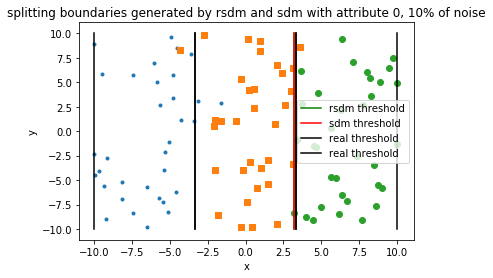

In [208]:
set3_100, t = generate_2Ddataset(0, 3, 100, 0.1, 0.1, [[-10, 10], [-10, 10]])
t1, h1 = discretize(rsdm, set3_100, 0)
t2, h2 = discretize(sdm, set3_100, 0)
display_discretizations_comparison(set3_100, t1, t2, t, 0, "splitting boundaries generated by rsdm and sdm with attribute 0, 10% of noise", "rsdm threshold", "sdm threshold")

In [209]:
sets3_100 = get_ten_folds(set3_100)

In [214]:
avg_accuracy = 0
avg_leaves = 0
avg_depth = 0
avg_ratio = 0
avg_pairs = 0
avg_evaluation = 0

for i in range(10):
    test_set = sets3_100[i]
    train_set = LabeledSet(2)
    for j in range(0, 10):
        if i != j:
            train_set.addExamples(sets3_100[j].x, sets3_100[j].y)
    tree = RDMT(rsdm, "shannon", 0, 100, 0.01, [1, 2, 3])
    tree.train(train_set)
    avg_accuracy += tree.accuracy(test_set)
    avg_leaves += tree.get_nb_leaves()
    avg_depth += tree.get_depth()
    avg_ratio += tree.get_ratio_non_monotone_pairs() 
    avg_pairs += tree.get_total_pairs()
    avg_evaluation += tree.evaluate_monotonicity()
        
avg_accuracy = avg_accuracy * (1.0/10)
avg_leaves = avg_leaves * (1.0/10)
avg_depth = avg_depth * (1.0/10)
avg_ratio = avg_ratio * (1.0/10)
avg_pairs = avg_pairs * (1.0/10)
avg_evaluation = avg_evaluation * (1.0/10)

print("average accuracy : ", avg_accuracy)
print("average depth : ", avg_depth)
print("average number of leaves : ", avg_leaves)
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", avg_ratio)
print("average number of pairs used for ratio computing : ", avg_pairs)
print("average rank shannon evaluation : ", avg_evaluation)

average accuracy :  0.9111111111111111
average depth :  5.800000000000001
average number of leaves :  9.200000000000001
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.9644281644281645
average number of pairs used for ratio computing :  2.7
average rank shannon evaluation :  0.1116847612358744


In [215]:
avg_accuracy = 0
avg_leaves = 0
avg_depth = 0
avg_ratio = 0
avg_pairs = 0
avg_evaluation = 0

for i in range(10):
    test_set = sets3_100[i]
    train_set = LabeledSet(2)
    for j in range(0, 10):
        if i != j:
            train_set.addExamples(sets3_100[j].x, sets3_100[j].y)
    tree = RDMT(sdm, "shannon", 0, 100, 0.01, [1, 2, 3])
    tree.train(train_set)
    avg_accuracy += tree.accuracy(test_set)
    avg_leaves += tree.get_nb_leaves()
    avg_depth += tree.get_depth()
    avg_ratio += tree.get_ratio_non_monotone_pairs() 
    avg_pairs += tree.get_total_pairs()
    avg_evaluation += tree.evaluate_monotonicity()
        
avg_accuracy = avg_accuracy * (1.0/10)
avg_leaves = avg_leaves * (1.0/10)
avg_depth = avg_depth * (1.0/10)
avg_ratio = avg_ratio * (1.0/10)
avg_pairs = avg_pairs * (1.0/10)
avg_evaluation = avg_evaluation * (1.0/10)

print("average accuracy : ", avg_accuracy)
print("average depth : ", avg_depth)
print("average number of leaves : ", avg_leaves)
print("average ratio between number of pairwise non-monotone label comparisons and number of pairs : ", avg_ratio)
print("average number of pairs used for ratio computing : ", avg_pairs)
print("average rank shannon evaluation : ", avg_evaluation)

average accuracy :  0.9222222222222222
average depth :  5.0
average number of leaves :  8.4
average ratio between number of pairwise non-monotone label comparisons and number of pairs :  0.9564645231311899
average number of pairs used for ratio computing :  2.7
average rank shannon evaluation :  0.09082380715352983


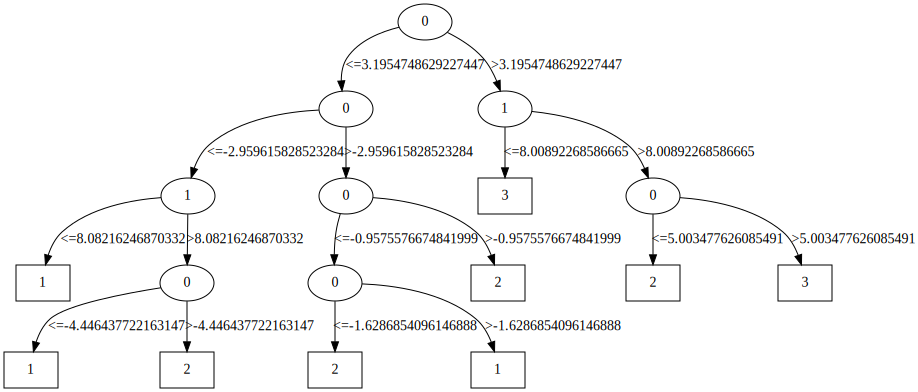

In [216]:
tree.plot()